In [108]:
import pandas as pd
import numpy as np
from numpy import log, sqrt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from matplotlib import pyplot
import matplotlib.pyplot as plt

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

pd.options.display.float_format = '{:.5f}'.format

import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

## Traditional Time Series Model Example: Missouri Drug Overdoses

In [2]:
# Reading in opioid overdose data
overdoses_temp = pd.read_csv('Data/monthly_opioid_overdose_counts.csv')
overdoses_temp.head()

,state,month,period,drug,overdoses
0,US,4/2015,12 month-ending,Number of Drug Overdose Deaths,1072
1,US,8/2015,12 month-ending,Number of Drug Overdose Deaths,1070
2,US,12/2015,12 month-ending,Number of Drug Overdose Deaths,1087
3,US,2/2015,12 month-ending,Number of Drug Overdose Deaths,1107
4,US,1/2015,12 month-ending,Number of Drug Overdose Deaths,1108


In [3]:
overdoses_temp.dtypes

state        object
month        object
period       object
drug         object
overdoses     int64
dtype: object

In [4]:
# Converting to date/time and sorting data by month
overdoses_temp['month'] = pd.to_datetime(overdoses_temp['month'], format='%m/%Y')
overdoses_temp = overdoses_temp[['month','overdoses']].sort_values('month')

In [5]:
# Split data into training and validation data
overdoses = overdoses_temp.iloc[0:66, :]
test_set = overdoses_temp.iloc[66:, :].sort_values('month')
overdoses

,month,overdoses
4,2015-01-01,1108
3,2015-02-01,1107
7,2015-03-01,1092
0,2015-04-01,1072
8,2015-05-01,1093
...,...,...
63,2020-02-01,1631
67,2020-03-01,1655
60,2020-04-01,1749
68,2020-05-01,1834


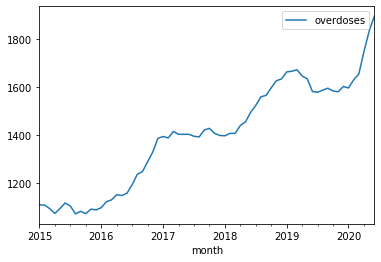

In [6]:
# Plot overall trend
overdoses.plot(x='month')

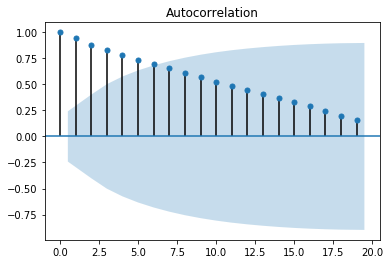

In [7]:
# Plot autocorrelation plot of raw overdose data
plot_acf(overdoses['overdoses'])
pyplot.show()

#### The above graph shows data with a trend, meaning it will not be stationary

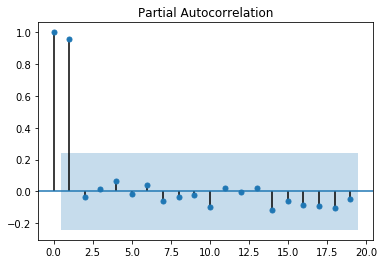

In [8]:
plot_pacf(overdoses['overdoses'])
pyplot.show()

#### The autocorrelation had a gradual decrease and the PACF had a sharp decrease. If this data were stationary, only an AR model would be necessary (no MA). According to the above graph, if this data were stationary, it would require an AR order value of 2.

### Testing for stationarity with Dickey-Fuller test
The above shows that the p-value is not significant, meaning we fail to reject the null hypothesis that the data is  not stationary

In [9]:
# Perform augmented Dickey-Fuller test to test for stationarity
result = adfuller(overdoses['overdoses'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.230206
p-value: 0.973906
Critical Values:
	1%: -3.558
	5%: -2.917
	10%: -2.596


#### Calculating the first difference of the time series to try to achieve stationarity

In [178]:
first_diff = overdoses.copy()
first_diff['first_diff'] = first_diff['overdoses'] - first_diff['overdoses'].shift(1)
test_set['first_diff'] = test_set['overdoses'] - test_set['overdoses'].shift(1)
first_diff
first_diff = first_diff.dropna(axis=0)
test_set = test_set.dropna(axis=0)
first_diff.head()

,month,overdoses,first_diff
3,2015-02-01,1107,-1.00000
7,2015-03-01,1092,-15.00000
0,2015-04-01,1072,-20.00000
8,2015-05-01,1093,21.00000
6,2015-06-01,1116,23.00000


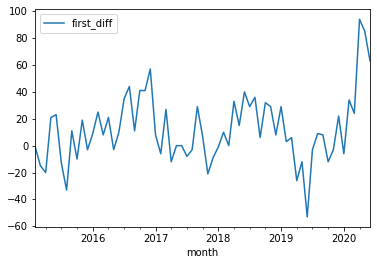

In [11]:
# Plotting the second differenced data
first_diff[['month','first_diff']].plot(x='month')

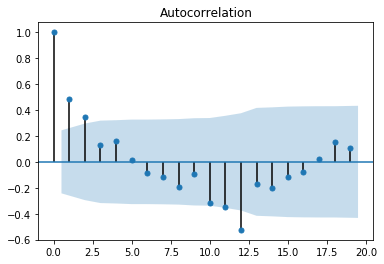

In [12]:
plot_acf(first_diff['first_diff'])
pyplot.show()

#### We see a gradual decrease for each lag meaning a MA parameter is necessary. The graph above indicates that if the first differenced would need a MA parameter of 3 would be necessary if the data is stationary. 

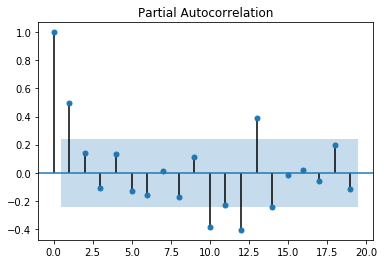

In [13]:
plot_pacf(first_diff['first_diff'])
pyplot.show()

#### We see a gradual decrease for each lag meaning a AR is necessary. The graph above indicates that if the first differenced would need a AR order of 2 would be necessary if the data is stationary. 

### Testing for stationarity with Dickey-Fuller test
The above shows that the p-value is significant, meaning we can reject the null hypothesis that the data is not stationary. Our first differenced data is stationary and can be used in an ARIMA model.

In [14]:
# Perform augmented Dickey-Fuller test to test for stationarity
result = adfuller(first_diff['first_diff'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.153146
p-value: 0.000000
Critical Values:
	1%: -3.560
	5%: -2.918
	10%: -2.597


In [15]:
# Calculate a second differencing of the data set
high_diff = overdoses.copy()
high_diff['diff'] = high_diff['overdoses'] - high_diff['overdoses'].shift(2)
high_diff = high_diff.dropna(axis=0)
high_diff.head()

,month,overdoses,diff
7,2015-03-01,1092,-16.00000
0,2015-04-01,1072,-35.00000
8,2015-05-01,1093,1.00000
6,2015-06-01,1116,44.00000
5,2015-07-01,1103,10.00000


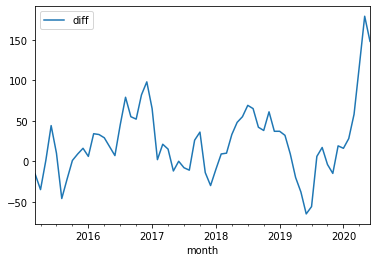

In [16]:
# Plotting the second differenced data
high_diff[['month','diff']].plot(x='month')

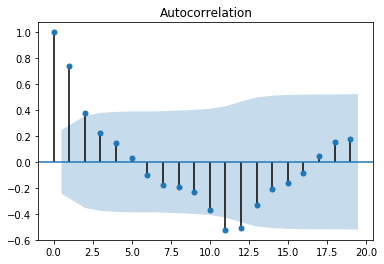

In [17]:
# Plot the autocorrelation of the second differenced data
plot_acf(high_diff['diff'])
pyplot.show()

#### We see a gradual decrease for each lag meaning a MA parameter is necessary. The graph above indicates that if the first differenced would need a MA parameter of 2 or 3 would be necessary if the data is stationary. 

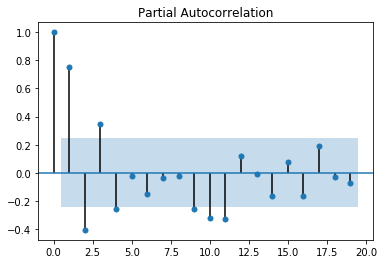

In [18]:
# Plot the partial autocorrelation of the second differenced data
plot_pacf(high_diff['diff'])
pyplot.show()

#### We see a gradual decrease for each lag meaning an AR order is necessary. The graph above indicates that if the first differenced would need a AR order of 4-5 would be necessary if the data is stationary. 

In [19]:
# Perform augmented Dickey-Fuller test to test for stationarity
result = adfuller(high_diff['diff'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.255095
p-value: 0.000007
Critical Values:
	1%: -3.560
	5%: -2.918
	10%: -2.597


### Testing for stationarity with Dickey-Fuller test
The above shows that the p-value is significant, meaning we can reject the null hypothesis that the data is not stationary. Our first differenced data is stationary and can be used in an ARIMA model.

#### If differencing doesn't work, you can also transform your data. Differencing worked in our case so this may not be necessary, but I want to show an example. The most common transformation are log and square root transformations.

In [20]:
log_trans = overdoses.copy()
log_trans['exp_od'] = log(log_trans['overdoses'])
#log_trans['exp_od'] = log_trans['exp_od'] - log_trans['exp_od'].shift(1)
log_trans.head()

,month,overdoses,exp_od
4,2015-01-01,1108,7.01031
3,2015-02-01,1107,7.00941
7,2015-03-01,1092,6.99577
0,2015-04-01,1072,6.97728
8,2015-05-01,1093,6.99668


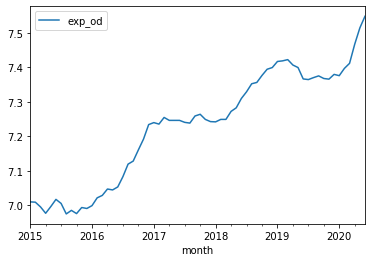

In [21]:
# Plot log transformed data
log_trans[['month','exp_od']].plot(x='month')

#### There is a clear trend so this data will not be stationary

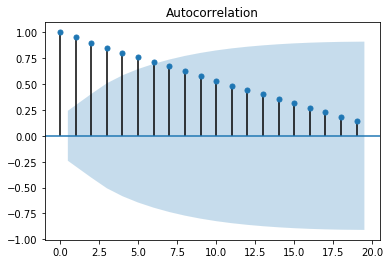

In [22]:
plot_acf(log_trans['exp_od'])
pyplot.show()

#### The above graph confirms the data has a trend, meaning it will not be stationary

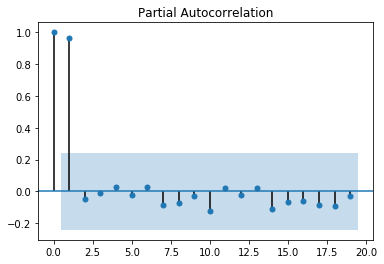

In [23]:
plot_pacf(log_trans['exp_od'])
pyplot.show()

#### The autocorrelation had a gradual decrease and the PACF had a sharp decrease. If this data were stationary, only an AR model would be necessary (no MA). According to the above graph, if this data were stationary, it would require an AR order value of 2.

### Testing for stationarity with Dickey-Fuller test
The above shows that the p-value is not significant, meaning we fail to reject the null hypothesis that the data is  not stationary

In [24]:
# Perform augmented Dickey-Fuller test to test for stationarity
result = adfuller(log_trans['exp_od'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.167244
p-value: 0.942315
Critical Values:
	1%: -3.539
	5%: -2.909
	10%: -2.592


In [25]:
# Performed a square root transformation and tested multiple differencing strategies afterwards
sqrt_trans = overdoses.copy()
sqrt_trans['sqrt_od'] = sqrt(sqrt_trans['overdoses'])
sqrt_trans['sqrt_od'] = sqrt_trans['sqrt_od'] - sqrt_trans['sqrt_od'].shift(5)
sqrt_trans = sqrt_trans.dropna(axis=0)
sqrt_trans.head()

,month,overdoses,sqrt_od
6,2015-06-01,1116,0.11995
5,2015-07-01,1103,-0.06017
1,2015-08-01,1070,-0.33457
11,2015-09-01,1081,0.13715
10,2015-10-01,1071,-0.33441


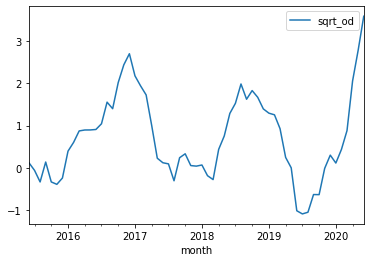

In [26]:
# Plots the square root transformed data
sqrt_trans[['month','sqrt_od']].plot(x='month')

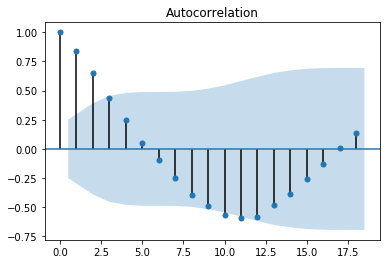

In [27]:
# Plotting autocorrelation
plot_acf(sqrt_trans['sqrt_od'])
pyplot.show()

#### ACF has a gradual decrease so we need an AR term

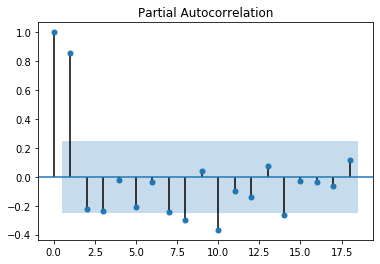

In [28]:
plot_pacf(sqrt_trans['sqrt_od'])
pyplot.show()

#### The autocorrelation had a gradual decrease and the PACF had a sharp decrease. If this data were stationary, only an AR model would be necessary (no MA). According to the above graph, if this data were stationary, it would require an AR order value of 2.

### Testing for stationarity with Dickey-Fuller test
The above shows that the p-value is significant, meaning we can reject the null hypothesis that the data is not stationary. Our first differenced data is stationary and can be used in an ARIMA model.

In [29]:
# Perform augmented Dickey-Fuller to test for stationarity
result = adfuller(sqrt_trans['sqrt_od'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.844435
p-value: 0.000045
Critical Values:
	1%: -3.566
	5%: -2.920
	10%: -2.598


### ARIMA Model #1
Tried:
- An AR order of 2
- Second differencing
- An MA parameter of 1

In [30]:
model1 = ARIMA(overdoses.overdoses, dates=overdoses.month, order=(2,2,1))
model_fit1 = model1.fit(disp=0)
print(model_fit1.summary())

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:           D2.overdoses   No. Observations:                   64
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -289.047
Method:                       css-mle   S.D. of innovations             22.088
Date:                Wed, 02 Feb 2022   AIC                            588.094
Time:                        22:48:48   BIC                            598.888
Sample:                    03-01-2015   HQIC                           592.346
                         - 06-01-2020                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.1626      1.392      0.835      0.407      -1.566       3.891
ar.L1.D2.overdoses    -0.0038      0.441     -0.009      0.993      -0.868       0.860
ar.L2.D2.overdoses  

### Results
The AR order of 2 is not significant and the MA parameter of 1 not is significant. This is NOT a good model.

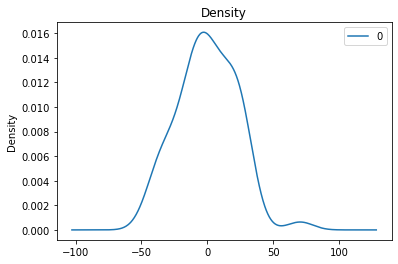

In [31]:
# Plot residual errors
residuals = pd.DataFrame([])
residuals = pd.DataFrame(model_fit1.resid)
residuals.plot(kind='kde', title='Density')
plt.show()

#### We can plot the residuals of the model to have an idea of how well the model is fitted. Basically, the residuals are the difference between the original values and the predicted values from the model.

### ARIMA Model #2
Tried:
- An AR order of 2
- First differencing
- An MA parameter of 3

In [32]:
model2 = ARIMA(overdoses.overdoses, dates=overdoses.month, order=(2,1,3))
model_fit2 = model2.fit(disp=0)
print(model_fit2.summary())

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:            D.overdoses   No. Observations:                   65
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -289.515
Method:                       css-mle   S.D. of innovations             20.009
Date:                Wed, 02 Feb 2022   AIC                            593.030
Time:                        22:48:48   BIC                            608.251
Sample:                    02-01-2015   HQIC                           599.036
                         - 06-01-2020                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                11.8340      5.173      2.287      0.026       1.694      21.974
ar.L1.D.overdoses     1.0452      0.156      6.684      0.000       0.739       1.352
ar.L2.D.overdoses    -0.

### Results
The AR order of 2 is significant and the MA parameter of 3 is significant. We are good to model this!

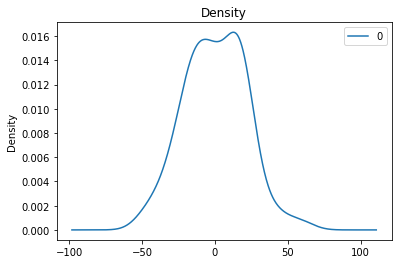

In [33]:
# Plot residual errors
residuals = pd.DataFrame([])
residuals = pd.DataFrame(model_fit2.resid)
residuals.plot(kind='kde', title='Density')
plt.show()

### Model 1 Validation

In [34]:
test_set['predictions_model1'] = model_fit1.forecast(steps=11)[0]
test_set.head()

,month,overdoses,first_diff,predictions_model1
61,2020-08-01,1907,-11.00000,1966.61693
71,2020-09-01,1900,-7.00000,2036.89450
70,2020-10-01,1917,17.00000,2108.44986
69,2020-11-01,1927,10.00000,2181.15694
62,2020-12-01,1915,-12.00000,2255.02904


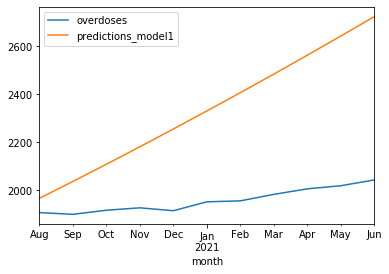

In [35]:
test_set[['month','overdoses','predictions_model1']].plot(x='month')

In [38]:
MSE = mean_squared_error(test_set['overdoses'], test_set['predictions_model1'])
MAE = mean_absolute_error(test_set['overdoses'], test_set['predictions_model1'])

print("Model 1 MSE is: " + str(MSE))
print("Model 1 MAE is: " + str(MAE))

Model 1 MSE is: 181328.6933297132
Model 1 MAE is: 379.06688206668696


### Model 1 Results
The graph and the model metrics show model 1 is a bad fit

In [42]:
test_set['predictions_model2'] = model_fit2.forecast(steps=11)[0]
test_set.head()

,month,overdoses,first_diff,predictions_model1,predictions_model2
61,2020-08-01,1907,-11.00000,1966.61693,1946.71160
71,2020-09-01,1900,-7.00000,2036.89450,1973.41814
70,2020-10-01,1917,17.00000,2108.44986,1977.33404
69,2020-11-01,1927,10.00000,2181.15694,1971.45274
62,2020-12-01,1915,-12.00000,2255.02904,1969.79724


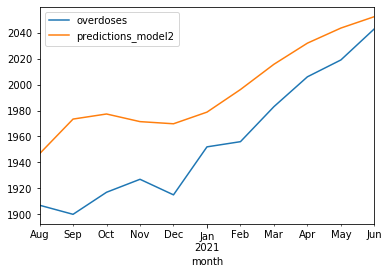

In [43]:
test_set[['month','overdoses','predictions_model2']].plot(x='month')

In [44]:
MSE = mean_squared_error(test_set['overdoses'], test_set['predictions_model2'])
MAE = mean_absolute_error(test_set['overdoses'], test_set['predictions_model2'])

print("Model 2 MSE is: " + str(MSE))
print("Model 2 MAE is: " + str(MAE))

Model 2 MSE is: 1850.0449806134638
Model 2 MAE is: 39.29483392762786


### Model 2 Results
The graph and the model metrics show model 2 is not a great fit but much better than model 1

## Retail Time Series Model Example: Prophet Models

In [46]:
# Read in retain data
train = pd.read_csv('Data/train.csv')
train.head()

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [47]:
# Printing minimum and maximum date in the data set to inform size of the validation data set
print("max date: " + str(train.Date.max()))
print("min date: " + str(train.Date.min()))

max date: 2015-07-31
min date: 2013-01-01


In [48]:
# Aggregate all sales to a daily level across stores
ts_data_temp = train.groupby('Date')['Sales'].sum().reset_index()
ts_data_temp.head()

,Date,Sales
0,2013-01-01,97235
1,2013-01-02,6949829
2,2013-01-03,6347820
3,2013-01-04,6638954
4,2013-01-05,5951593


In [49]:
# Confirming date is in date/time format
ts_data_temp.dtypes

Date     object
Sales     int64
dtype: object

In [50]:
# Convert to date/time format
ts_data_temp['Date'] = pd.to_datetime(ts_data_temp['Date'])
ts_data_temp.rename(columns={'Date':'ds',
                        'Sales':'y'},inplace=True)
ts_data_temp.dtypes

ds    datetime64[ns]
y              int64
dtype: object

In [51]:
ts_data_temp.head()

,ds,y
0,2013-01-01,97235
1,2013-01-02,6949829
2,2013-01-03,6347820
3,2013-01-04,6638954
4,2013-01-05,5951593


In [52]:
# Split into a training and validation data set
ts_data = ts_data_temp.iloc[0:850, :]
test_sales = ts_data_temp.iloc[850:,:]

print("max date: " + str(ts_data.ds.max()))
print("min date: " + str(test_sales.min()))

max date: 2015-04-30 00:00:00
min date: ds    2015-05-01 00:00:00
y                  249207
dtype: object


In [53]:
# Find sales summary statistics
test_sales['y'].describe()

count         92.00000
mean     6617716.15217
std      3287024.40162
min       249207.00000
25%      6284784.50000
50%      6956487.50000
75%      8622252.75000
max     11916672.00000
Name: y, dtype: float64

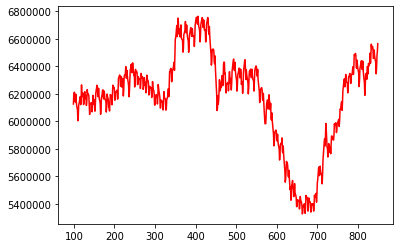

In [59]:
# Visualize a rolling average plot of sales data. Rolling average window is 100 days.
rolling = ts_data['y'].rolling(window=100)
rolling_mean = rolling.mean()
rolling_mean.plot(color='red')
pyplot.show()

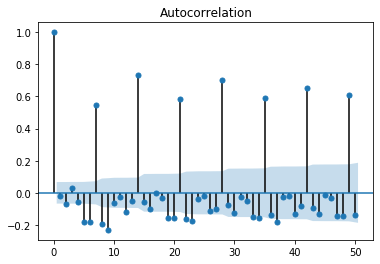

In [60]:
# Plot autocorrelation plots
plot_acf(ts_data['y'], lags=50)
pyplot.show()

#### The autocorrelation plot shows that there is seasonality in the data. ARIMA models will not work.

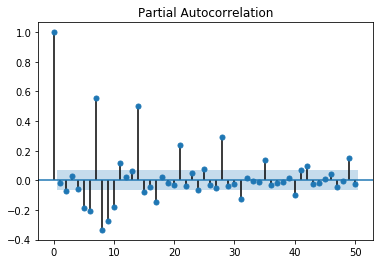

In [61]:
plot_pacf(ts_data['y'], lags=50)
pyplot.show()

In [62]:
# Perform augmented Dickey-Fuller test to test for stationarity
result = adfuller(ts_data['y'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.605418
p-value: 0.000126
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


#### Dickey-Fuller test shows the data is stationary. However, with the seasonality in the data, we need to choose a model that accounts for that. We could use SARIMA but I will show Prophet models. These models give us additional information that is useful for retail models

## Plot Default Prophet Model

In [106]:
# Running Prophet models
m = Prophet()
# Fitting the model
m.fit(ts_data)
# Making a data frame of the size of 92 days, the length of our validation data set
future = m.make_future_dataframe(periods=92)
# Use fitted model to make the predictions
forecast = m.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be r

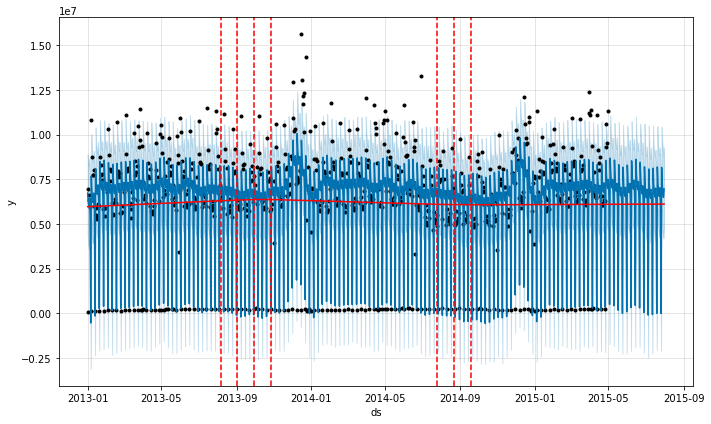

In [110]:
# Plot the time series data with changepoints and forecast
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [ ]:
# Plot time series component charts
fig2 = m.plot_components(forecast)

### Model insights
- Strong increase in trend at the end of 2013
- Sales are strongest on Monday, Tuesday and Friday. Sunday sales are extremely low.
- Holiday sales are the highest, indicating we need to incorporate the holiday effect to the models
- The yearly seasonality was relatively stable outside of the holidays

### Plotting model changepoints

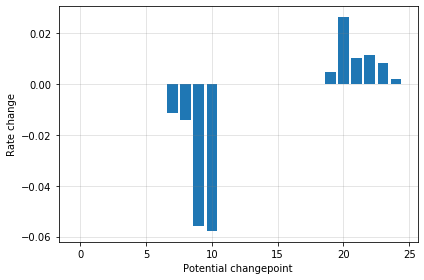

In [66]:
deltas = m.params['delta'].mean(0)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

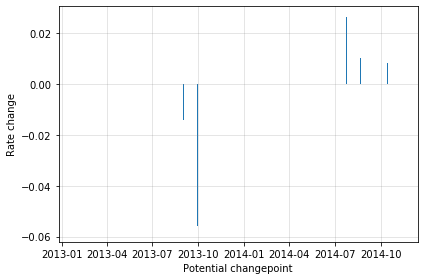

In [105]:
deltas = pd.concat([pd.DataFrame([m.changepoints]).T.reset_index(), pd.DataFrame(m.params['delta'][0])], axis=1).drop(columns='index')
deltas.rename(columns={0:'deltas'},inplace=True)

fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(deltas['ds'],deltas['deltas'])
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

In [47]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,5969059.61510,4492261.31164,8980819.50988,5969059.61510,5969059.61510,763383.67033,763383.67033,763383.67033,1294244.87112,1294244.87112,1294244.87112,-530861.20079,-530861.20079,-530861.20079,0.00000,0.00000,0.00000,6732443.28543
1,2013-01-02,5970600.68983,3924975.81545,8559439.36769,5970600.68983,5970600.68983,240045.79920,240045.79920,240045.79920,799017.38403,799017.38403,799017.38403,-558971.58482,-558971.58482,-558971.58482,0.00000,0.00000,0.00000,6210646.48903
2,2013-01-03,5972141.76456,3743817.84155,8152683.52838,5972141.76456,5972141.76456,-14428.23946,-14428.23946,-14428.23946,558976.50202,558976.50202,558976.50202,-573404.74148,-573404.74148,-573404.74148,0.00000,0.00000,0.00000,5957713.52510
3,2013-01-04,5973682.83928,4178307.12054,8635168.63615,5973682.83928,5973682.83928,464425.28473,464425.28473,464425.28473,1039000.84711,1039000.84711,1039000.84711,-574575.56238,-574575.56238,-574575.56238,0.00000,0.00000,0.00000,6438108.12401
4,2013-01-05,5975223.91401,3327865.74056,7830042.72045,5975223.91401,5975223.91401,-481932.46745,-481932.46745,-481932.46745,81214.05099,81214.05099,81214.05099,-563146.51844,-563146.51844,-563146.51844,0.00000,0.00000,0.00000,5493291.44656


In [111]:
# Storing predictions for final model evaluation
predicted_sales = forecast[forecast['ds'] >= test_sales.ds.min()].reset_index()
test_sales = test_sales.reset_index()
test_sales['predictions_model1'] = predicted_sales['yhat']
test_sales.head()

,index,ds,y,predictions_model1
0,850,2015-05-01,264231,7487777.99558
1,851,2015-05-02,8764984,6545586.85640
2,852,2015-05-03,249207,499140.38310
3,853,2015-05-04,10995906,8684846.85372
4,854,2015-05-05,8778928,7775889.32208


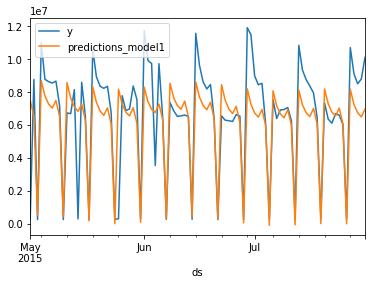

In [112]:
test_sales[['ds','y','predictions_model1']].plot(x='ds')

## Add Holidays to Prophet Model

In [113]:
m = Prophet()
m.add_country_holidays(country_name='US')
m.fit(ts_data)
future = m.make_future_dataframe(periods=92)
forecast = m.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be r

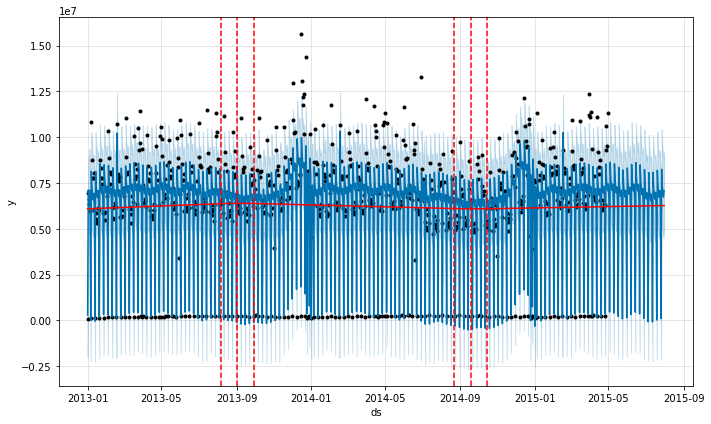

In [114]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be r

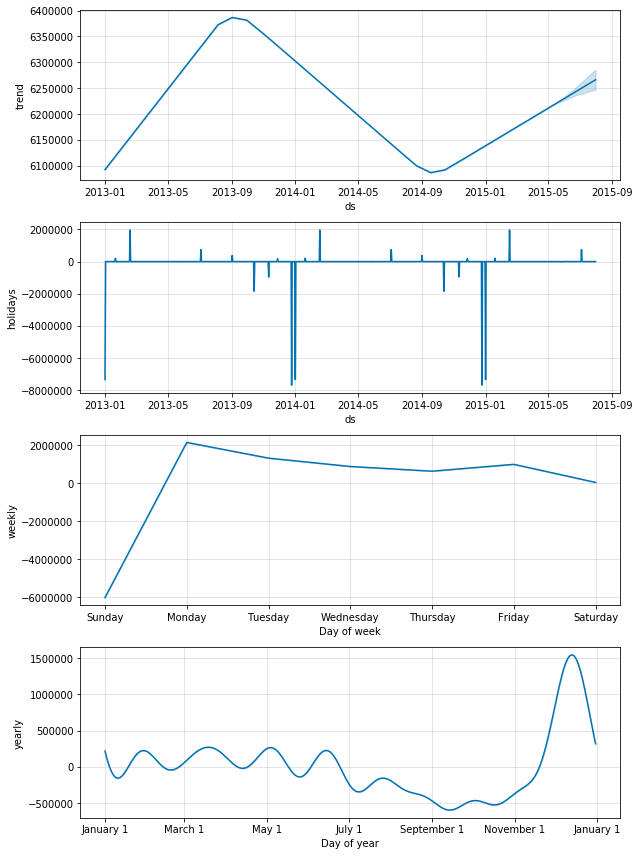

In [115]:
fig2 = m.plot_components(forecast)

### Christmas holiday effect is less dramatic than the previous model where we did not control for the holiday effect

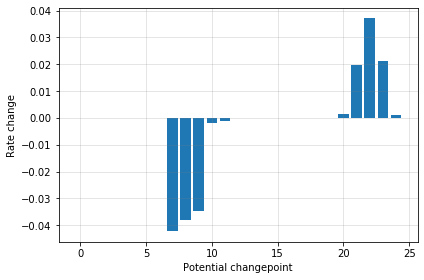

In [118]:
deltas = m.params['delta'].mean(0)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

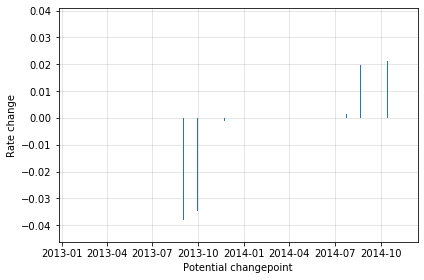

In [119]:
deltas = pd.concat([pd.DataFrame([m.changepoints]).T.reset_index(), pd.DataFrame(m.params['delta'][0])], axis=1).drop(columns='index')
deltas.rename(columns={0:'deltas'},inplace=True)

fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(deltas['ds'],deltas['deltas'])
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

In [120]:
# Storing predictions for final model evaluation
predicted_sales = forecast[forecast['ds'] >= test_sales.ds.min()].reset_index()
test_sales = test_sales.reset_index()
test_sales['predictions_model2'] = predicted_sales['yhat']

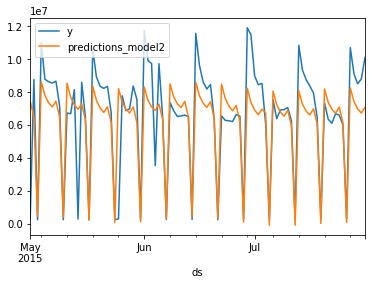

In [121]:
test_sales[['ds','y','predictions_model2']].plot(x='ds')

## Change Model to Multiplicative Since Seasonality Changes

In [122]:
m = Prophet(seasonality_mode='multiplicative')
m.add_country_holidays(country_name='US')
m.fit(ts_data)
future = m.make_future_dataframe(periods=92)
forecast = m.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be r

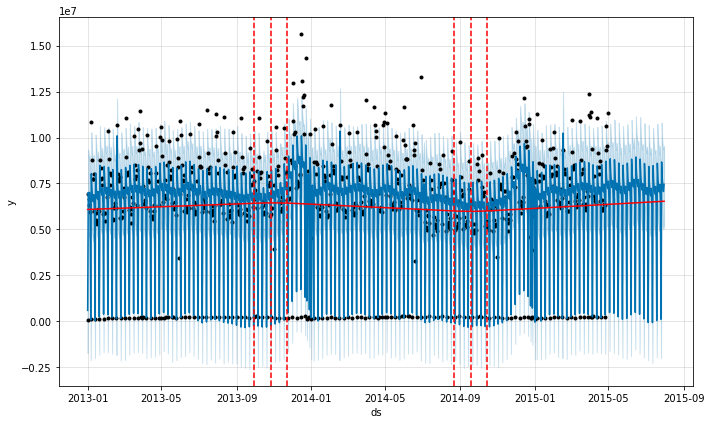

In [123]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be r

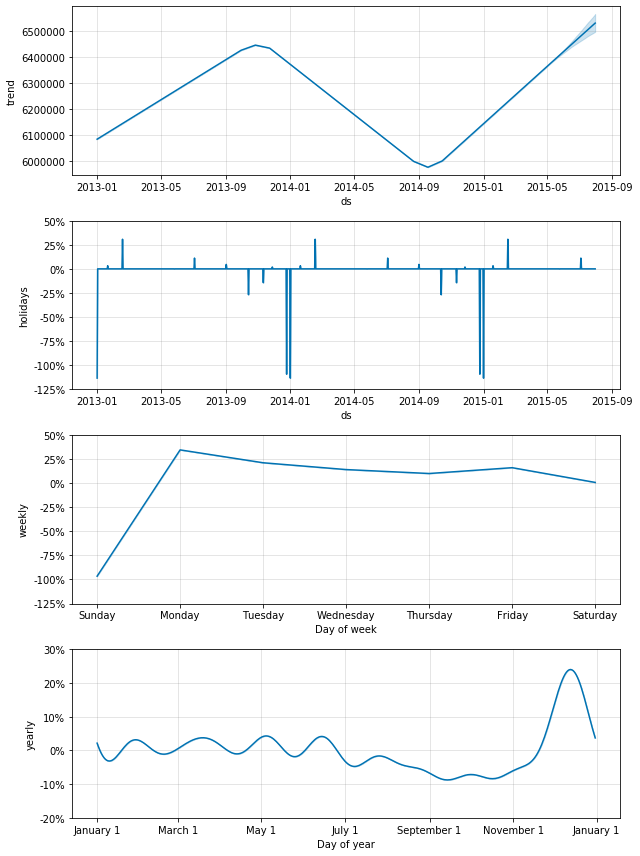

In [124]:
fig2 = m.plot_components(forecast)

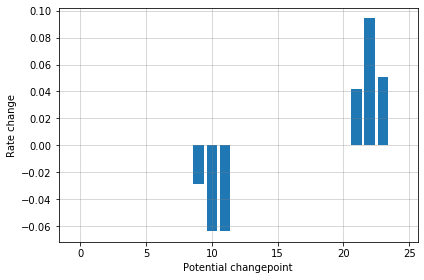

In [59]:
deltas = m.params['delta'].mean(0)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.3)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

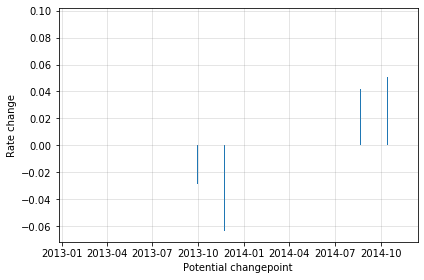

In [125]:
deltas = pd.concat([pd.DataFrame([m.changepoints]).T.reset_index(), pd.DataFrame(m.params['delta'][0])], axis=1).drop(columns='index')
deltas.rename(columns={0:'deltas'},inplace=True)

fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(deltas['ds'],deltas['deltas'])
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

In [126]:
# Storing predictions for final model evaluation
predicted_sales = forecast[forecast['ds'] >= test_sales.ds.min()].reset_index()
test_sales['predictions_model3'] = predicted_sales['yhat']

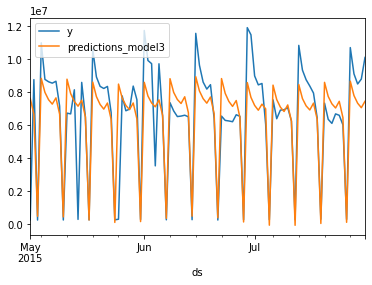

In [61]:
test_sales[['ds','y','predictions_model3']].plot(x='ds')

## Change Model to Have More Flexible Trend to Reduce Overfitting (higher changepoint_prior_scale)

In [165]:
m = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale=0.2)
m.add_country_holidays(country_name='US')
m.fit(ts_data)
future = m.make_future_dataframe(periods=92)
forecast = m.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be r

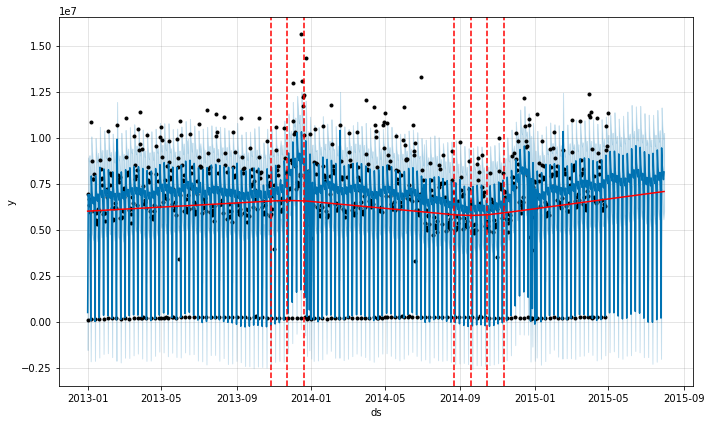

In [166]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be r

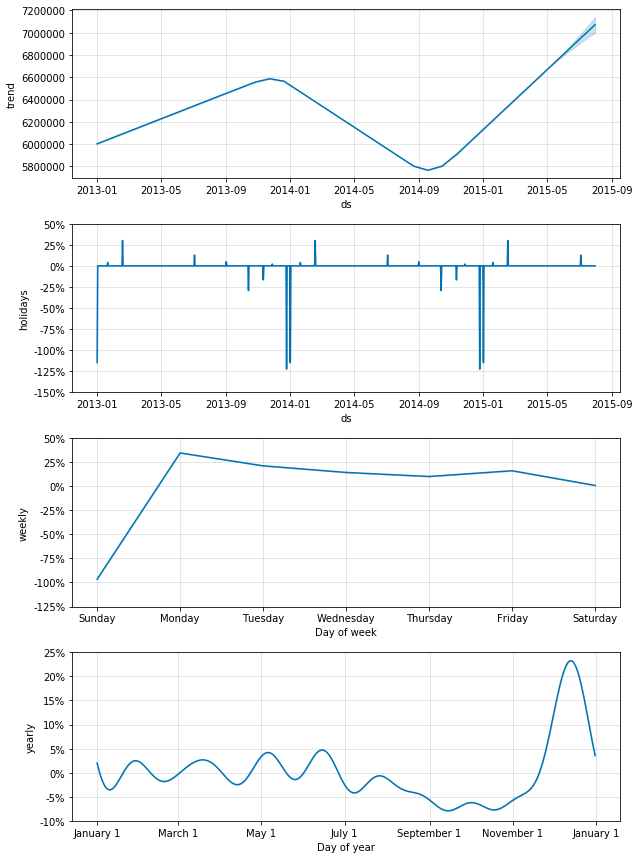

In [167]:
fig2 = m.plot_components(forecast)

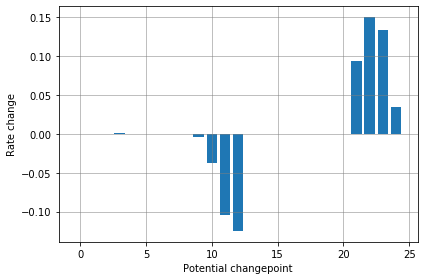

In [168]:
deltas = m.params['delta'].mean(0)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.5)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

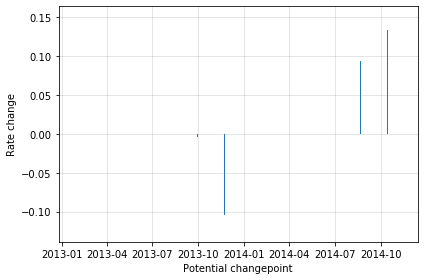

In [169]:
deltas = pd.concat([pd.DataFrame([m.changepoints]).T.reset_index(), pd.DataFrame(m.params['delta'][0])], axis=1).drop(columns='index')
deltas.rename(columns={0:'deltas'},inplace=True)

fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(deltas['ds'],deltas['deltas'])
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

In [170]:
# Storing predictions for final model evaluation
predicted_sales = forecast[forecast['ds'] >= test_sales.ds.min()].reset_index()
test_sales['predictions_model4'] = predicted_sales['yhat']

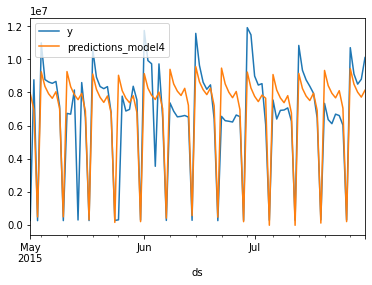

In [171]:
test_sales[['ds','y','predictions_model4']].plot(x='ds')

In [174]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
print('Default Prophet Model')
print('model1 mse is: ' + str(mean_squared_error(test_sales['y'], test_sales['predictions_model1'])))
print('model1 mae is: ' + str(mean_absolute_error(test_sales['y'], test_sales['predictions_model1'])))

print('Prophet Model with Holidays')
print('model2 mse is: ' + str(mean_squared_error(test_sales['y'], test_sales['predictions_model2'])))
print('model2 mae is: ' + str(mean_absolute_error(test_sales['y'], test_sales['predictions_model2'])))

print('Change Model to Multiplicative Seasonality')
print('model3 mse is: ' + str(mean_squared_error(test_sales['y'], test_sales['predictions_model3'])))
print('model3 mae is: ' + str(mean_absolute_error(test_sales['y'], test_sales['predictions_model3'])))

print('Change Model to Have More Flexible Trend and Reduce Overfitting')
print('model4 mse is: ' + str(mean_squared_error(test_sales['y'], test_sales['predictions_model4'])))
print('model4 mae is: ' + str(mean_absolute_error(test_sales['y'], test_sales['predictions_model4'])))

Default Prophet Model
model1 mse is: 3974057329134.314
model1 mae is: 1370810.2891069052
Prophet Model with Holidays
model2 mse is: 3893172808476.0127
model2 mae is: 1349606.3923761516
Change Model to Multiplicative Seasonality
model3 mse is: 3711395229761.0396
model3 mae is: 1295227.1128024312
Change Model to Have More Flexible Trend and Reduce Overfitting
model4 mse is: 3757869972817.6064
model4 mae is: 1276182.6980298397
